In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler  # 使用 MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns  
import joblib

# 设置文件路径
weather_file = r'E:\rgzn\data\Summary_of_Weather.csv'
stations_file = r'E:\rgzn\data\Weather_Station_Locations.csv'

# 🚀 **1. 读取天气数据**
weather_data = pd.read_csv(weather_file, low_memory=False)

# 🚀 **2. 强制转换所有列为数值型**
weather_data = weather_data.apply(pd.to_numeric, errors='coerce')

# 🚀 **3. 读取站点数据**
stations_data = pd.read_csv(stations_file)

# 🚀 **4. 选择用于建模的特征**
weather_features = weather_data[['Precip', 'Snowfall', 'MaxTemp', 'MinTemp', 'PRCP', 'MO', 'YR', 'DA']]
station_features = stations_data[['ELEV', 'Latitude', 'Longitude']]

target = weather_data['MeanTemp']

# 🚀 **5. 处理缺失值**
print("\n🔍 缺失值统计（处理前）:")
print(weather_features.isnull().sum())
print(station_features.isnull().sum())

# - 使用 SimpleImputer 填充 NaN
imputer = SimpleImputer(strategy='mean')  # 使用均值填充 NaN
weather_features = pd.DataFrame(imputer.fit_transform(weather_features), columns=weather_features.columns)
station_features = pd.DataFrame(imputer.fit_transform(station_features), columns=station_features.columns)

# 处理目标变量
target = target.fillna(target.mean())  # 填充目标变量的 NaN

# - 再次检查 NaN 是否全部去除
print("\n✅ 缺失值统计（处理后）:")
print(weather_features.isnull().sum())
print(station_features.isnull().sum())

# 🚀 **6. 确保数据没有 NaN**
if weather_features.isnull().sum().sum() > 0 or station_features.isnull().sum().sum() > 0 or target.isnull().sum() > 0:
    print("❌ 仍然有 NaN，检查数据预处理步骤！")
    exit()

# 🚀 **7. 检查每列的方差**
print("\n🔍 检查每列的方差:")
print(weather_features.var())  # 检查天气特征的方差
print(station_features.var())  # 检查站点特征的方差

# 如果有方差为0的列，可以直接删除
weather_features = weather_features.loc[:, weather_features.var() != 0]
station_features = station_features.loc[:, station_features.var() != 0]

# 🚀 **8. 检查是否有无效值（如 Inf 或极端值）**
print("\n🔍 检查无效值（如 Inf 和极端值）:")
print("Weather features contain inf:", np.isinf(weather_features).sum())
print("Station features contain inf:", np.isinf(station_features).sum())

# 将无效值替换为 NaN
weather_features.replace([np.inf, -np.inf], np.nan, inplace=True)
station_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# 🚀 **9. 删除极端值：使用统计方法去除异常值**
# 假设我们用 Z-score 来去除异常值（根据实际情况调整）
from scipy.stats import zscore

# 计算 Z-score
weather_zscores = np.abs(zscore(weather_features))
station_zscores = np.abs(zscore(station_features))

# 设置阈值 (例如阈值 3 即去除 Z-score 大于 3 的数据)
weather_features = weather_features[(weather_zscores < 3).all(axis=1)]
station_features = station_features[(station_zscores < 3).all(axis=1)]
target = target[weather_features.index]  # 确保目标变量与特征数据对齐

# 🚀 **10. 合并特征数据**
combined_features = pd.concat([weather_features, station_features], axis=1)

# 🚀 **11. 使用 MinMaxScaler 进行标准化**
scaler = MinMaxScaler()  # 使用 MinMaxScaler
features_scaled = scaler.fit_transform(combined_features)

# 🚀 **12. 确保数据中没有 NaN**
if np.isnan(features_scaled).sum() > 0:
    print("标准化后的数据包含 NaN")
    # 如果发现NaN，可以填充或删除：
    features_scaled = np.nan_to_num(features_scaled, nan=np.nanmean(features_scaled))
    print("已用均值填充 NaN！")

# 🚀 **13. 划分数据集**
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# 🚀 **14. 训练线性回归模型**
model = LinearRegression()
model.fit(X_train, y_train)

# 🚀 **15. 预测**
y_pred = model.predict(X_test)

# 🚀 **16. 计算 MSE 和 R²**
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📈 Mean Squared Error (MSE): {mse:.3f}")
print(f"📊 R^2 Score: {r2:.3f}")



🔍 缺失值统计（处理前）:
Precip      15572
Snowfall     1106
MaxTemp         0
MinTemp         0
PRCP        17365
MO              0
YR              0
DA              0
dtype: int64
ELEV         0
Latitude     0
Longitude    0
dtype: int64

✅ 缺失值统计（处理后）:
Precip      0
Snowfall    0
MaxTemp     0
MinTemp     0
PRCP        0
MO          0
YR          0
DA          0
dtype: int64
ELEV         0
Latitude     0
Longitude    0
dtype: int64

🔍 检查每列的方差:
Precip      114.246926
Snowfall      6.969930
MaxTemp      75.878663
MinTemp      69.303645
PRCP          0.176724
MO           11.741940
YR            1.295815
DA           77.306200
dtype: float64
ELEV         3.259161e+06
Latitude     4.645260e+02
Longitude    7.466466e+03
dtype: float64

🔍 检查无效值（如 Inf 和极端值）:
Weather features contain inf: Precip      0
Snowfall    0
MaxTemp     0
MinTemp     0
PRCP        0
MO          0
YR          0
DA          0
dtype: int64
Station features contain inf: ELEV         0
Latitude     0
Longitude    0
dtype: int64
标准化

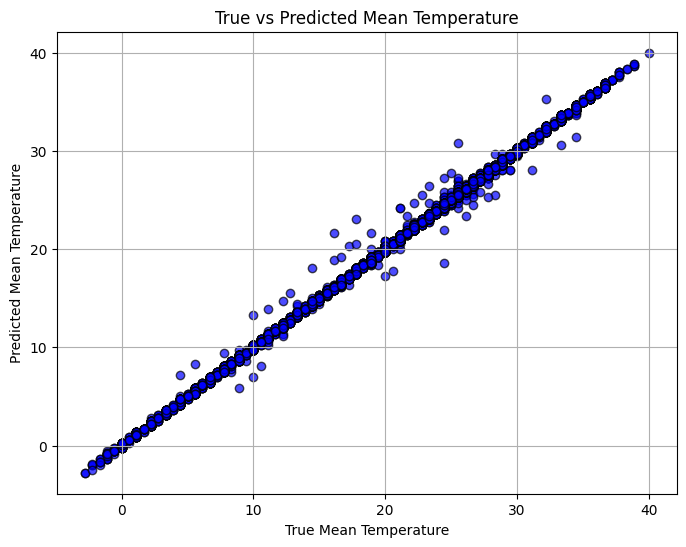

In [8]:
# 🚀 **17. 可视化预测结果**
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', edgecolor='k')
plt.xlabel("True Mean Temperature")
plt.ylabel("Predicted Mean Temperature")
plt.title("True vs Predicted Mean Temperature")
plt.grid()
plt.show()

In [9]:
# 🚀 **18. 输出线性回归的系数**
print("\n📢 线性回归模型的特征权重:")
for feature, coef in zip(combined_features.columns, model.coef_):
    print(f"{feature}: {coef:.4f}")

# 🚀 **19. 保存模型**
joblib.dump(model, "linear_regression_model.pkl")
print("\n✅ 线性回归模型已保存为 linear_regression_model.pkl")


📢 线性回归模型的特征权重:
Precip: 0.0611
Snowfall: 0.0183
MaxTemp: 24.4504
MinTemp: 20.5420
PRCP: -0.0479
MO: -0.0004
YR: 0.0029
DA: -0.0029
ELEV: -0.0407
Latitude: -0.0984
Longitude: 0.0788

✅ 线性回归模型已保存为 linear_regression_model.pkl


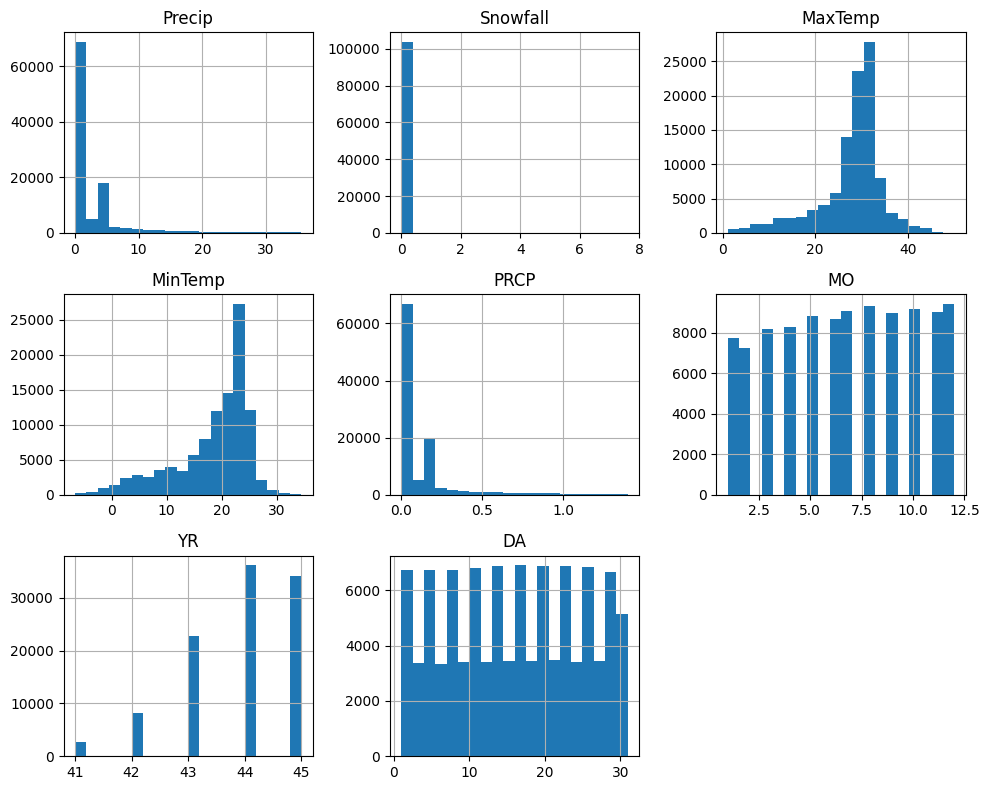

In [10]:
# 可视化特征分布：直方图
weather_features.hist(bins=20, figsize=(10, 8))
plt.tight_layout()
plt.show()

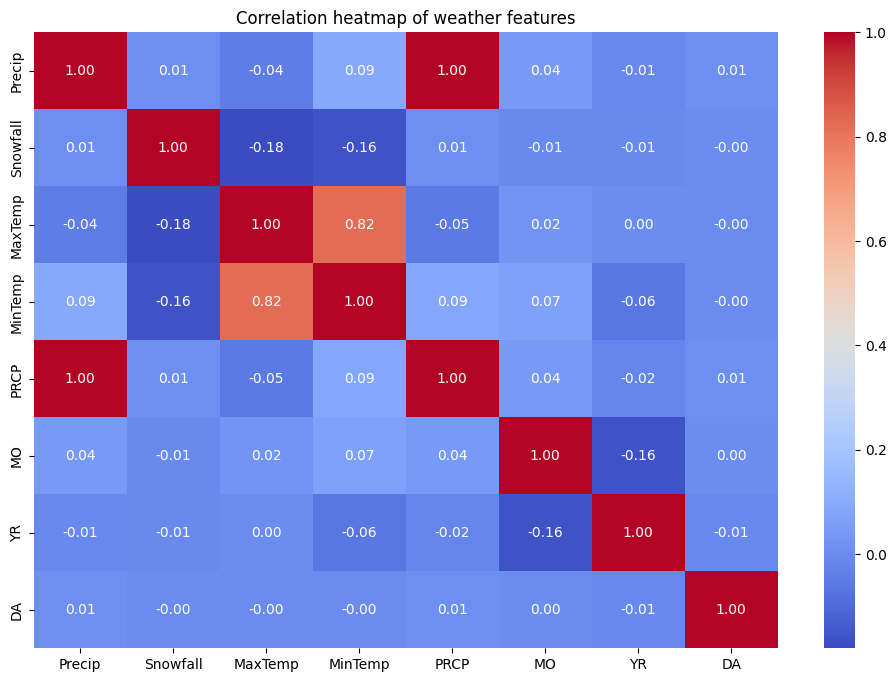

In [11]:
# 可视化特征相关性：热图
plt.figure(figsize=(12, 8))
sns.heatmap(weather_features.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation heatmap of weather features')
plt.show()

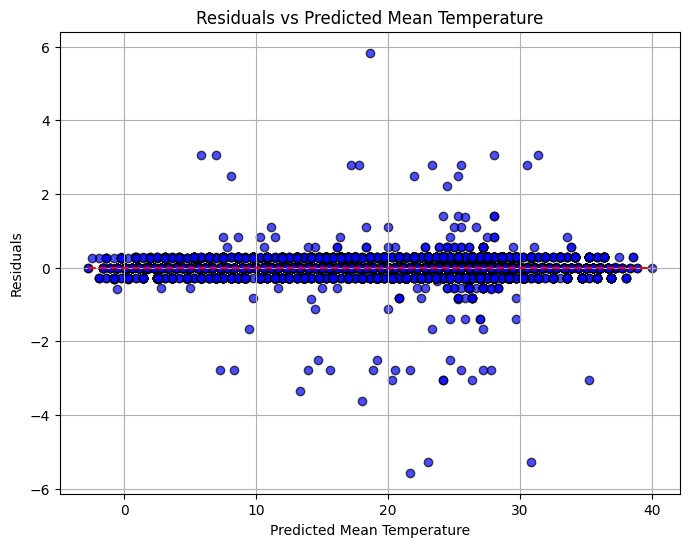

In [12]:
# 残差图
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.7, color='blue', edgecolor='k')
plt.hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), colors='r', linestyles='--')
plt.xlabel('Predicted Mean Temperature')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Mean Temperature')
plt.grid()
plt.show()

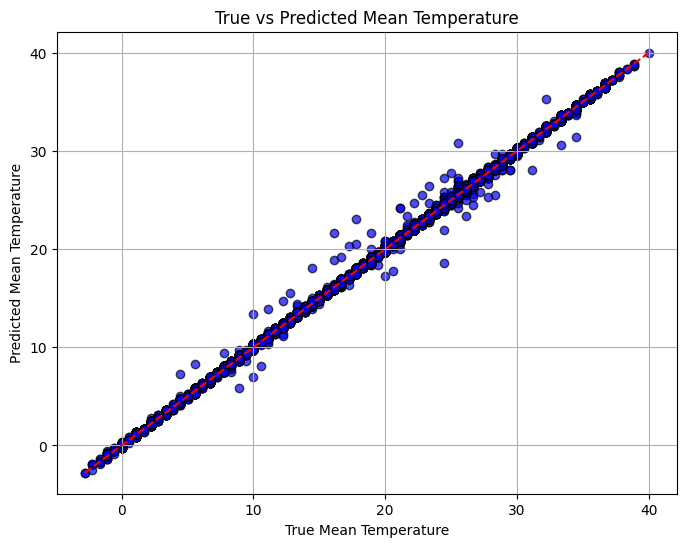

In [13]:
# 真实值与预测值的对比图（带拟合线）
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', edgecolor='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("True Mean Temperature")
plt.ylabel("Predicted Mean Temperature")
plt.title("True vs Predicted Mean Temperature")
plt.grid()
plt.show()